In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install ydata-profiling demoji nltk scikit-learn gensim pyLDAvis textblob spacy textstat transformers torch

In [109]:
import requests, os
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import demoji
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
import torch
from textstat import flesch_reading_ease # exploring text complixity
from transformers import BertTokenizer, BertModel

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [54]:
folder_path = 'data'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

url = "https://github.com/DenisPeskov/2020_acl_diplomacy/raw/master/data/train.jsonl"
response = requests.get(url)

if response.status_code == 200:
    filename = os.path.join(folder_path, os.path.basename(url))
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"File '{filename}' has been downloaded and saved to '{folder_path}'.")
else:
    print(f"Failed to download {url}. Status code: {response.status_code}")

File 'data\train.jsonl' has been downloaded and saved to 'data'.


In [5]:
df=pd.read_json('data/train.jsonl', lines=True)
df.head(2)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   messages                189 non-null    object
 1   sender_labels           189 non-null    object
 2   receiver_labels         189 non-null    object
 3   speakers                189 non-null    object
 4   receivers               189 non-null    object
 5   absolute_message_index  189 non-null    object
 6   relative_message_index  189 non-null    object
 7   seasons                 189 non-null    object
 8   years                   189 non-null    object
 9   game_score              189 non-null    object
 10  game_score_delta        189 non-null    object
 11  players                 189 non-null    object
 12  game_id                 189 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 19.3+ KB


In [7]:
df.loc[0]

messages                  [Germany!\n\nJust the person I want to speak w...
sender_labels             [True, True, True, True, True, True, True, Tru...
receiver_labels           [True, True, True, True, NOANNOTATION, NOANNOT...
speakers                  [italy, germany, italy, germany, italy, italy,...
receivers                 [germany, italy, germany, italy, germany, germ...
absolute_message_index    [74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...
relative_message_index    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
seasons                   [Spring, Spring, Spring, Spring, Spring, Sprin...
years                     [1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...
game_score                [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...
game_score_delta          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
players                                                    [italy, germany]
game_id                                                                   1
Name: 0, dty

In [8]:
df.loc[0]['messages']

['Germany!\n\nJust the person I want to speak with. I have a somewhat crazy idea that I’ve always wanted to try with I/G, but I’ve never actually convinced the other guy to try it. And, what’s worse, it might make you suspicious of me. \n\nSo...do I suggest it?\n\nI’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? That’s my hope anyway.\n\nWhat is your appetite like for unusual and crazy?',
 "You've whet my appetite, Italy. What's the suggestion?",
 '👍',
 "It seems like there are a lot of ways that could go wrong...I don't see why France would see you approaching/taking Munich--while I do nothing about it--and not immediately feel skittish",
 'Yeah, I can’t say I’ve tried it and it works, cause I’ve never tried it or seen it. But how I think it would work is (a) my Spring move looks like an attack on Austria, so it would not be surprising if you did not cover Munich. Then (b) you build two armies, w

In [9]:
df[df['game_id'] == 1]['players']

0       [italy, germany]
1       [italy, austria]
2        [italy, russia]
3       [italy, england]
4        [italy, turkey]
5        [italy, france]
6     [germany, austria]
7      [germany, russia]
8     [germany, england]
9      [germany, turkey]
10     [germany, france]
11     [austria, russia]
12    [austria, england]
13     [austria, turkey]
14     [austria, france]
15     [russia, england]
16      [russia, turkey]
17      [russia, france]
18     [england, turkey]
19     [england, france]
20      [turkey, france]
Name: players, dtype: object

In [10]:
game_ids = []
senders = []
receivers = []
messages = []
sender_labels = []
receiver_labels = []

for i, j in df.iterrows():       
    for c, d in enumerate(j['messages']):
        #print(c)
        game_ids.append(j['game_id'])
        senders.append(j['speakers'][c])
        receivers.append(j['receivers'][c])
        messages.append(j['messages'][c])
        sender_labels.append(j['sender_labels'][c])
        receiver_labels.append(j['receiver_labels'][c])
        
new_df = pd.DataFrame({'game_id': game_ids, 'sender': senders, 'receiver' : receivers ,'message': messages ,
                       'sender_label': sender_labels, 'receiver_label': receiver_labels })
new_df

,game_id,sender,receiver,message,sender_label,receiver_label
0,1,italy,germany,Germany!\n\nJust the person I want to speak wi...,True,True
1,1,germany,italy,"You've whet my appetite, Italy. What's the sug...",True,True
2,1,italy,germany,👍,True,True
3,1,germany,italy,It seems like there are a lot of ways that cou...,True,True
4,1,italy,germany,"Yeah, I can’t say I’ve tried it and it works, ...",True,NOANNOTATION
...,...,...,...,...,...,...
13127,10,france,england,Is there any way of me actually ending this co...,True,True
13128,10,france,england,Can we agree on peace? What are your demands?,True,True
13129,10,england,france,"Neutrality in exchange for current holdings, S...",True,False
13130,10,france,england,"Thats a bit too much, can I keep Spain and i h...",True,True


In [11]:
new_df.loc[2]['message'].split()

['👍']

In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13132 entries, 0 to 13131
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   game_id         13132 non-null  int64 
 1   sender          13132 non-null  object
 2   receiver        13132 non-null  object
 3   message         13132 non-null  object
 4   sender_label    13132 non-null  bool  
 5   receiver_label  13132 non-null  object
dtypes: bool(1), int64(1), object(4)
memory usage: 525.9+ KB


---
#### messages are annotated by the sender for their intended truthfulness and by the receiver for their perceived truthfulness
https://convokit.cornell.edu/documentation/diplomacy.html

---

In [55]:
# is there any entry in dataset where sender intention is not labled?
new_df[new_df['sender_label'] == 'NOANNOTATION']

,game_id,sender,receiver,message,sender_label,receiver_label,processesd_messages,emojis


In [56]:
# when reciver could not get the intention, what was the sender intent?
new_df[new_df['receiver_label'] == 'NOANNOTATION']['sender_label'].value_counts()

True     1061
False      46
Name: sender_label, dtype: int64

In [57]:
# when reciver detect the senders intent to be deceptive, what was the sender intent?
new_df[new_df['receiver_label'] == True]['sender_label'].value_counts()

True     10979
False      480
Name: sender_label, dtype: int64

In [58]:
# when reciver detect the senders intent to be *not* deceptive, what was the sender intent?
new_df[new_df['receiver_label'] == False]['sender_label'].value_counts()

True     501
False     65
Name: sender_label, dtype: int64

---
**EDA**

In [17]:
ProfileReport(new_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**The Preprocessing steps:**
1. **Replacing URLs:** Links starting with **"http" or "https" or "www"** are replaced by **"URL"**.
2. **Replacing Countrynames:** 
3. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
4. **Removing Stopwords:** ?? Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
5. **Lemmatizing:** ?? Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

In [18]:
def text_preprocess(message):
    processed = []   
    for text in message:
        # replaace URLs
        text = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",' <URL>',text)  
        
        # Replace all non alphabets.
        #text = re.sub( "[^a-zA-Z0-9]", " ", text)  # this will replace emojies as well!
        
        # Remove HTML/XML tags (if any)
        text = re.sub(r'<.*?>', '', text)

        # Remove punctuation and symbols (not for now)
        # text = re.sub(r'[^\w\s]', '', text) 

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Remove whitespaces (including new lines and tabs)
        text = text.strip().replace("\n", " ").replace("\r", " ").replace("\t", " ")
        
        processed.append(text)       
    return processed

new_df['processesd_messages'] = text_preprocess(list(new_df['message']))

In [67]:
new_df['processesd_messages']

0        Germany!  Just the person I want to speak with...
1        You've whet my appetite, Italy. What's the sug...
2                                                        👍
3        It seems like there are a lot of ways that cou...
4        Yeah, I can’t say I’ve tried it and it works, ...
                               ...                        
13127    Is there any way of me actually ending this co...
13128        Can we agree on peace? What are your demands?
13129    Neutrality in exchange for current holdings, S...
13130    Thats a bit too much, can I keep Spain and i h...
13131                                           Any deals?
Name: processesd_messages, Length: 13132, dtype: object

**Analyzing text statistics**

<Axes: >

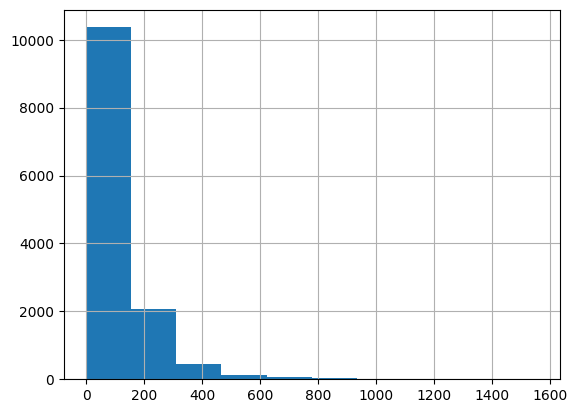

In [70]:
#number of conversations in each game
new_df['processesd_messages'].str.len().hist()

<Axes: >

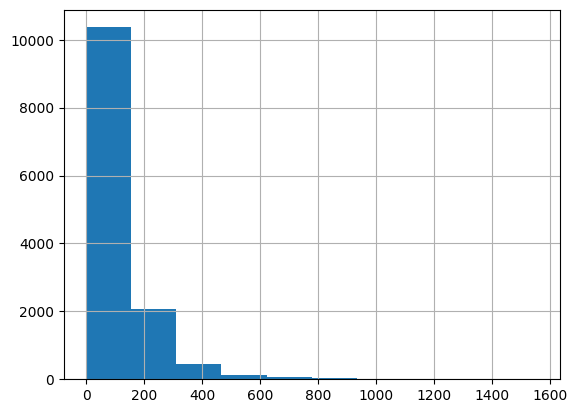

In [71]:
#number of characters in each message
new_df['processesd_messages'].str.len().hist()

<Axes: >

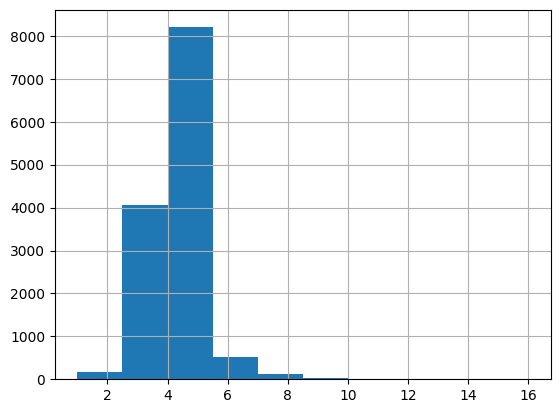

In [72]:
#  check the average word length in each message
new_df['processesd_messages'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()     

avaerage word lenth is between 1 to 10 with most word lengh to be 5

Is this the same for falshoods or true statements?

<Axes: >

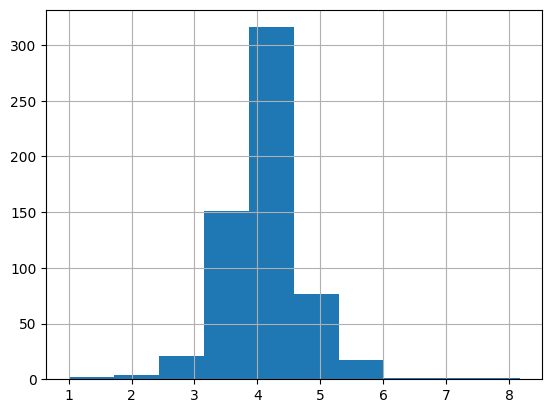

In [73]:
#  check the average word length in each message
new_df[new_df['sender_label'] == False]['processesd_messages'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()    

<Axes: >

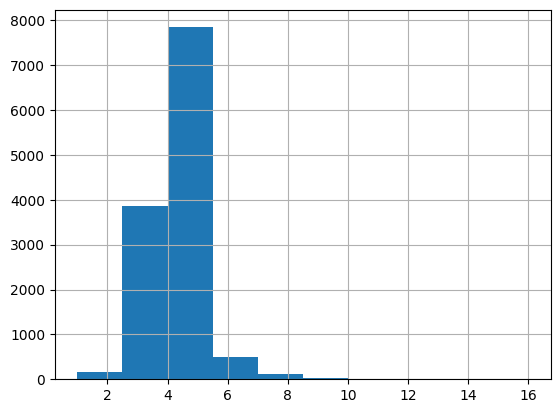

In [74]:
#  check the average word length in each message
new_df[new_df['sender_label'] == True]['processesd_messages'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()    

It looks like not!

however the dataset is not balanced and thiese comparisons cant really be useful!

In [75]:
# how many active players in each game:
new_df.groupby('game_id')['sender'].value_counts()

game_id  sender 
1        england    743
         italy      683
         germany    548
         france     313
         russia     156
                   ... 
10       england    148
         russia     108
         italy       83
         france      52
         turkey      14
Name: sender, Length: 62, dtype: int64

In [76]:
# how many active players in each game:
new_df.groupby('game_id')['receiver'].value_counts()

game_id  receiver
1        germany     729
         england     698
         italy       533
         france      263
         austria     194
                    ... 
10       austria     156
         england     143
         italy       103
         france       63
         turkey       19
Name: receiver, Length: 63, dtype: int64

In [26]:
#plot the above results:

<Axes: xlabel='sender_label', ylabel='count'>

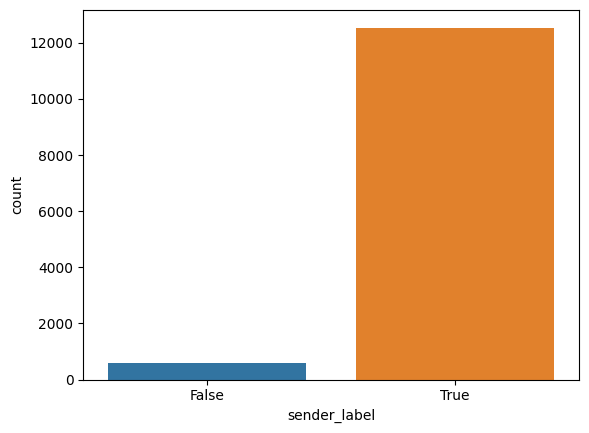

In [77]:
sns.countplot(new_df, x= 'sender_label')

<Axes: xlabel='receiver_label', ylabel='count'>

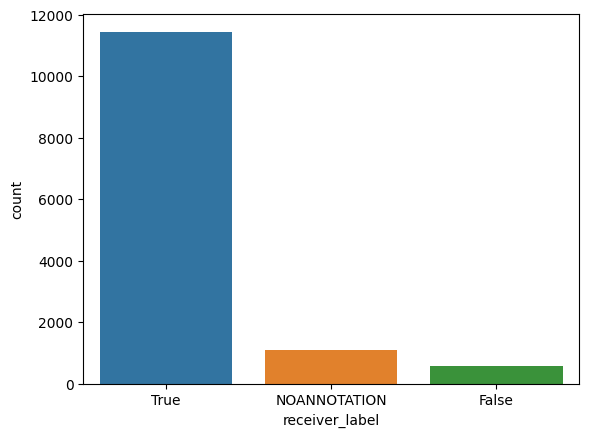

In [78]:
sns.countplot(new_df, x= 'receiver_label')

---
#### WordCloud
---

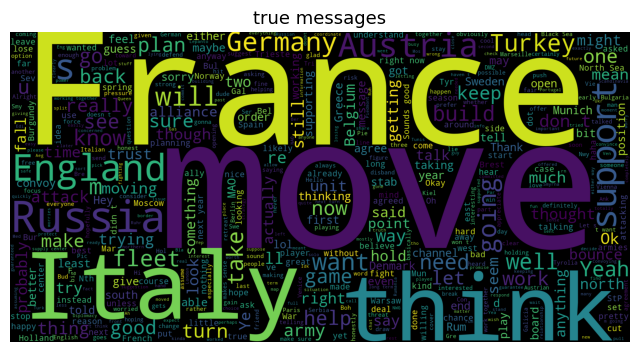

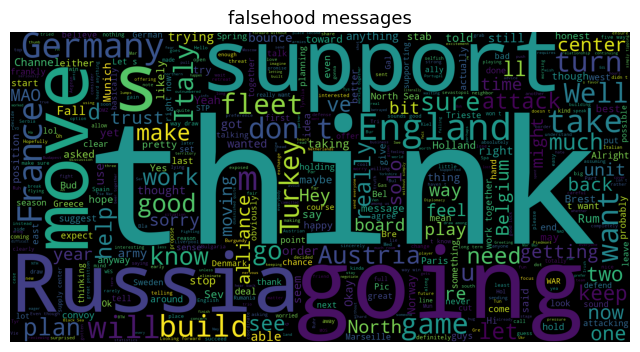

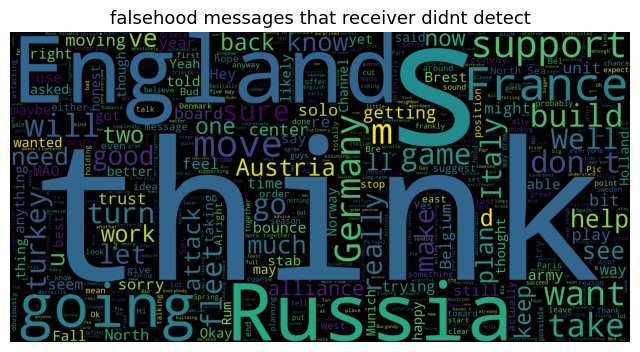

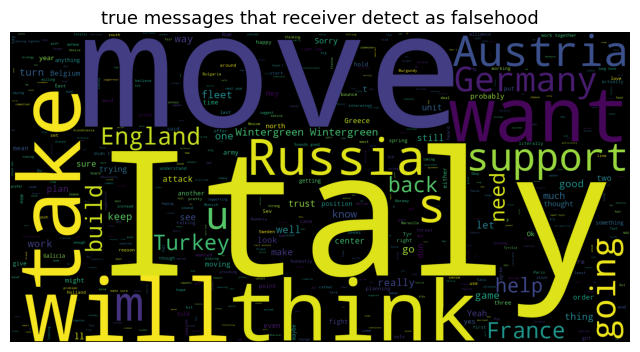

In [79]:
word_cloud_data = {
'true messages': new_df[new_df['sender_label'] == True]['processesd_messages'] ,
'falsehood messages': new_df[new_df['sender_label'] == False]['processesd_messages'],
'falsehood messages that receiver didnt detect': new_df[(new_df['sender_label'] == False) & (new_df['receiver_label'] == True)]['processesd_messages'] ,
'true messages that receiver detect as falsehood': new_df[(new_df['sender_label'] == True) & (new_df['receiver_label'] == False)]['processesd_messages']
}

for title, data in word_cloud_data.items(): 
    wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(data))  
    plt.figure(figsize = (8,6))
    plt.axis("off")
    plt.imshow(wc)
    plt.title(title,fontsize=13)
    plt.show()
    plt.close()
    


---

####  Do they lie more when using emojis?

---

In [30]:
emojis_list = []
for i in new_df['processesd_messages']: 
    a = demoji.findall(i)
    if a :
        emojis_list.append(','.join(a.keys()))
    else:
         emojis_list.append('NOEMOJI')
            
new_df['emojis']  = emojis_list

In [31]:
new_df[new_df['sender_label'] == False]['emojis'].value_counts()

NOEMOJI    568
🤗            4
🙂            3
👌            2
😁            2
😦            2
😉            2
🤭,🤫          1
🙄            1
😂            1
👍            1
😵            1
😛            1
🙃,😉          1
😅            1
Name: emojis, dtype: int64

In [32]:
new_df[new_df['sender_label'] == True]['emojis'].value_counts()

NOEMOJI    12137
🙂             75
😃             48
😂             36
😉             32
           ...  
😵              1
❤              1
😺              1
😭              1
🥳              1
Name: emojis, Length: 71, dtype: int64

In [33]:
emojis = {';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'':)',':)':
          'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised', ':-@': 'shocked',
          ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',           
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile'}

In [34]:
text = new_df[new_df['sender_label'] == True]['processesd_messages']
for char in text:
    if char in emojis:
        print(char)

:)


---
#### Ngram exploration

In [35]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]       
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<Axes: >

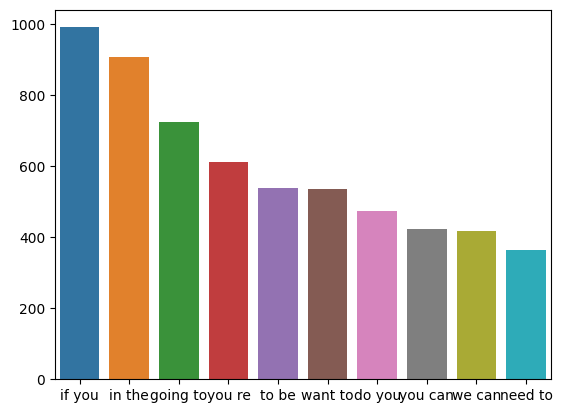

In [80]:
top_n_bigrams=get_top_ngram(new_df['processesd_messages'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=x,y=y)

<Axes: >

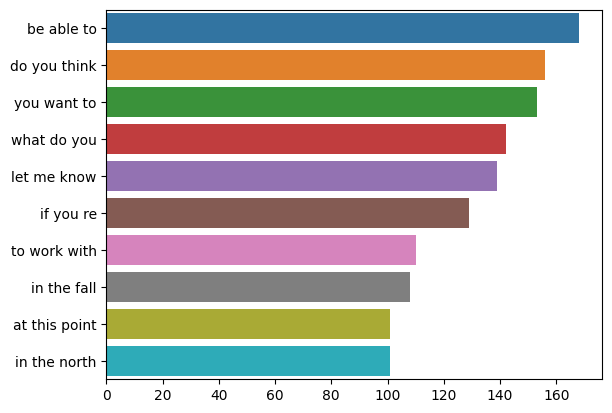

In [82]:
top_n_bigrams=get_top_ngram(new_df['processesd_messages'],3)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x = y ,y=x)

---
#### Topic modeling exploration

In [38]:
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
import nltk
nltk.download('stopwords') 
nltk.download('punkt')
nltk.download('wordnet')

def get_lda_objects(text):      
    stop=set(stopwords.words('english'))
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for t in text:
            words=[w for w in word_tokenize(t) if (w not in stop)]
            words=[lem.lemmatize(w) for w in words if len(w)>2]
            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, num_topics = 5,  id2word = dic, passes = 20, workers = 3)
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
lda_model, bow_corpus, dic = get_lda_objects(new_df['processesd_messages'])

In [40]:
lda_model.show_topics()

[(0,
  '0.021*"Italy" + 0.018*"Russia" + 0.017*"France" + 0.016*"Austria" + 0.016*"England" + 0.014*"n\'t" + 0.013*"Germany" + 0.013*"like" + 0.010*"think" + 0.010*"Turkey"'),
 (1,
  '0.014*"What" + 0.012*"get" + 0.011*"n\'t" + 0.010*"support" + 0.010*"army" + 0.010*"move" + 0.010*"year" + 0.009*"fleet" + 0.009*"going" + 0.009*"build"'),
 (2,
  '0.019*"think" + 0.018*"support" + 0.016*"move" + 0.015*"fleet" + 0.012*"Yeah" + 0.009*"\'ll" + 0.009*"good" + 0.009*"could" + 0.008*"going" + 0.008*"n\'t"'),
 (3,
  '0.016*"get" + 0.016*"France" + 0.014*"could" + 0.013*"move" + 0.013*"support" + 0.011*"build" + 0.010*"take" + 0.010*"fleet" + 0.010*"would" + 0.009*"n\'t"'),
 (4,
  '0.015*"would" + 0.015*"move" + 0.012*"Mun" + 0.011*"n\'t" + 0.010*"Sea" + 0.009*"see" + 0.008*"North" + 0.008*"That" + 0.008*"think" + 0.007*"need"')]

In [41]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.116096  0.119632       1        1  34.588028
3     -0.033529  0.017191       2        1  22.572971
2     -0.003984 -0.102124       3        1  15.802841
1     -0.034799 -0.092274       4        1  14.913185
4      0.188407  0.057574       5        1  12.122974, topic_info=        Term         Freq        Total Category  logprob  loglift
45    France  1293.000000  1293.000000  Default  30.0000  30.0000
203  support  1088.000000  1088.000000  Default  29.0000  29.0000
532    fleet   903.000000   903.000000  Default  28.0000  28.0000
466      Mun   242.000000   242.000000  Default  27.0000  27.0000
6       What   500.000000   500.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
137      get    91.489929  1216.655713   Topic5  -5.1749  -0.4776
160     back    74.841990   592.171561   Topic5  -5.3758   0.0417
281     plan    71.979417   545.916979   Topic5  -5.4148   0.0840
6       What    70.008751   500.098645   Topic5  -5.4425   0.1439
2    Germany    71.901503  1087.476437   Topic5  -5.4159  -0.6063

[423 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
143       1  0.166273   'll
143       2  0.281001   'll
143       3  0.327558   'll
143       4  0.064846   'll
143       5  0.159622   'll
...     ...       ...   ...
394       1  0.226222   yes
394       2  0.081440   yes
394       3  0.099538   yes
394       4  0.597227   yes
4591      2  0.956305  zone

[776 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])

---
#### Sentiment analysis

In [42]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

def sentiment_textblob(text):
        x = TextBlob(text).sentiment.polarity     
        if x<0:
            return 'negative'
        elif x==0:
            return 'neutral'
        else:
            return 'positove'

def plot_sentiment_barchart(text, method='TextBlob'):
    if method == 'TextBlob':
        sentiment = text.map(lambda x: sentiment_textblob(x))
    elif method == 'Vader':      
        sid = SentimentIntensityAnalyzer()
        sentiment = text.map(lambda x: sentiment_vader(x, sid=sid))
    else:
        raise ValueError('Textblob or Vader')
    
    plt.bar(sentiment.value_counts().index,sentiment.value_counts())
            

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


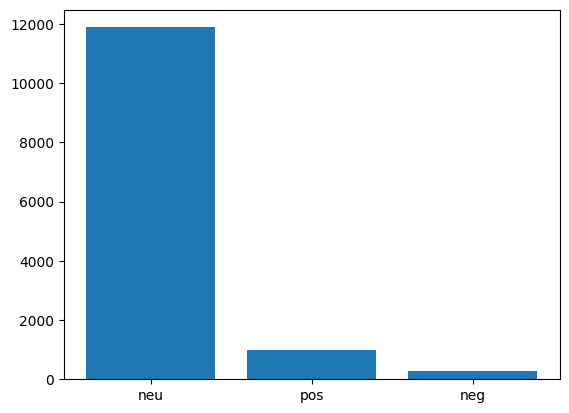

In [83]:
plot_sentiment_barchart(new_df['processesd_messages'], method='Vader')

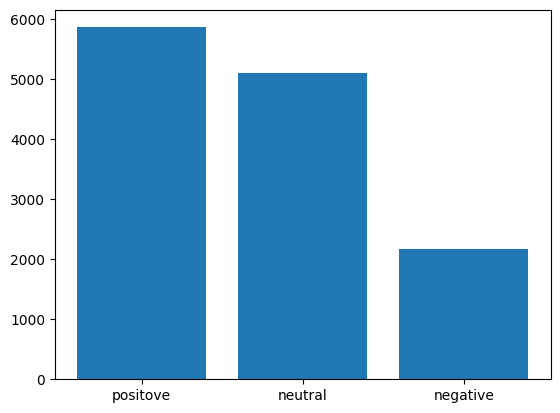

In [84]:
plot_sentiment_barchart(new_df['processesd_messages'], method='TextBlob')

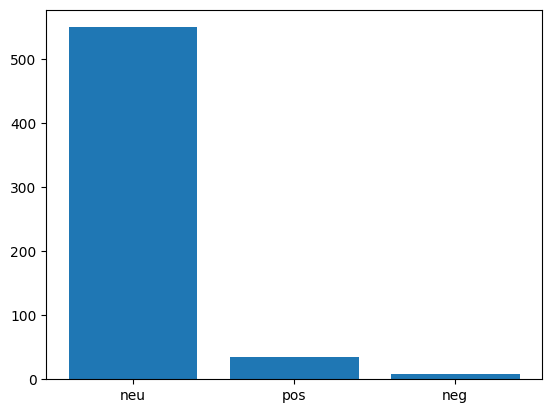

In [85]:
plot_sentiment_barchart(new_df[new_df['sender_label'] == False]['processesd_messages'], method='Vader')

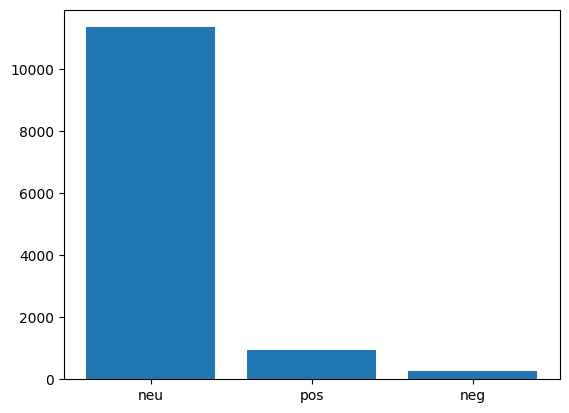

In [86]:
plot_sentiment_barchart(new_df[new_df['sender_label'] == True]['processesd_messages'], method='Vader')

---
#### Named entity recognition

In [47]:
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/12.8 MB ? eta -:--:--
                                              0.2/12.8 MB 7.6 MB/s eta 0:00:02
     --                                       0.8/12.8 MB 9.6 MB/s eta 0:00:02
     ----                                     1.4/12.8 MB 11.5 MB/s eta 0:00:01
     -------                                  2.3/12.8 MB 13.1 MB/s eta 0:00:01
     ----------                               3.4/12.8 MB 15.5 MB/s eta 0:00:01
     ---------------                          5.0/12.8 MB 18.7 MB/s eta 0:00:01
     ---------------------                    7.0/12.8 MB 22.3 MB/s eta 0:00:01
     ----------------------------             9.0/12.8 MB 25.2 MB/s eta 0:00:01
     ---------------------------------       10.9/12.8 MB 31.2 MB/s eta 0:00:01
     --------------------------------------  12.8/12.8 MB 38.5 MB/s eta 0:00:01
     --------------------------------------- 12.8/12


[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [87]:
from collections import  Counter
import spacy
nlp = spacy.load("en_core_web_sm")

def plot_named_entity_barchart(text):

    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]
    
    ent=text.apply(lambda x : _get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    
    x,y=map(list,zip(*count))
    sns.barplot(x=y,y=x)

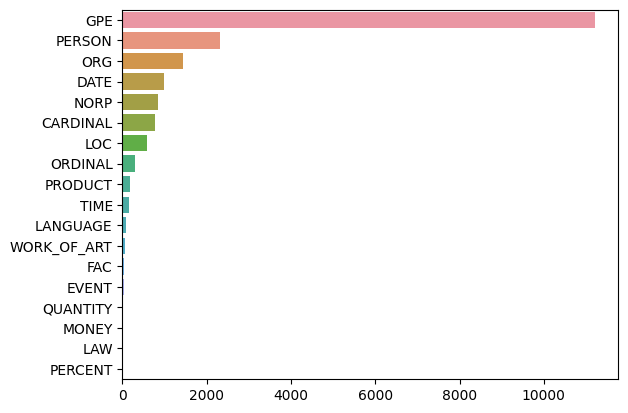

In [88]:
plot_named_entity_barchart(new_df['processesd_messages'])

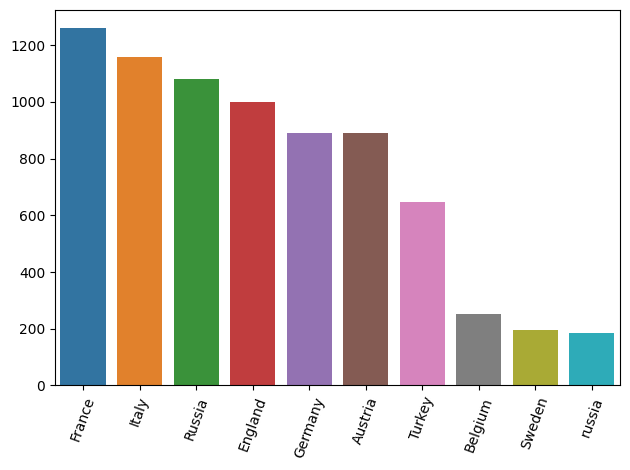

In [89]:
#  visualize the most common tokens per entity
def ner(text,ent="GPE"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe=new_df['processesd_messages'].apply(lambda x: ner(x))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y= y,x = x)
plt.xticks(rotation=70)
plt.tight_layout()

<Axes: >

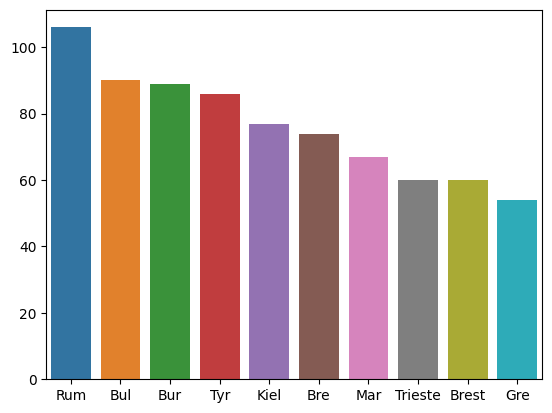

In [90]:
# the most common names that appeared
per=new_df['processesd_messages'].apply(lambda x: ner(x,"PERSON"))
per=[i for x in per for i in x]
counter=Counter(per)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y= y,x = x)

---
#### Exploration through parts of speech tagging

Noun (NN)

Verb (VB)

Adjective(JJ)

Adverb(RB)

Preposition (IN)

Conjunction (CC)

Pronoun(PRP)

Interjection (INT)

In [ ]:
nltk.download('averaged_perceptron_tagger')

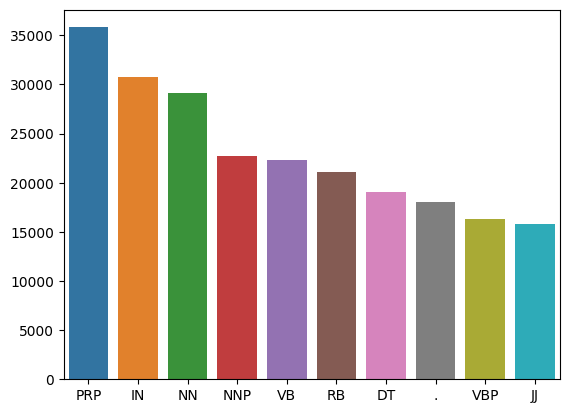

In [107]:
#pot the most common parts of speech in the text 
def plot_parts_of_speech(text_series):
    
    def _get_pos(text):
        if not text:
            return []        
        # Tokenizes the text + tags the parts of speech.
        pos = nltk.pos_tag(word_tokenize(text))
        if isinstance(pos, list) and all(isinstance(item, tuple) for item in pos):
            #  extract the parts of speech.
            pos_tags = [tag for _, tag in pos]
            return pos_tags
        else:
            # if 'pos' is not a list of tuples
            return []
        
    tags = text_series.apply(lambda x: _get_pos(x)) 
    tags = [x for l in tags for x in l]  # Flatten the list of tags.  
    counter = Counter(tags)  # Count the occurrence of each tag

    #  for the case when 'counter' is empty or doesn't have 10 elements
    most_common_tags = counter.most_common(min(10, len(counter)))

    if most_common_tags:  
        x, y = zip(*most_common_tags) 
        x= np.array(x)
        y= np.array(y)
        sns.barplot(x = x, y =y) 
    else:
        print("Not enough data to plot.")

plot_parts_of_speech(new_df['processesd_messages'])

---
#### Exploring through text complexity

<Axes: >

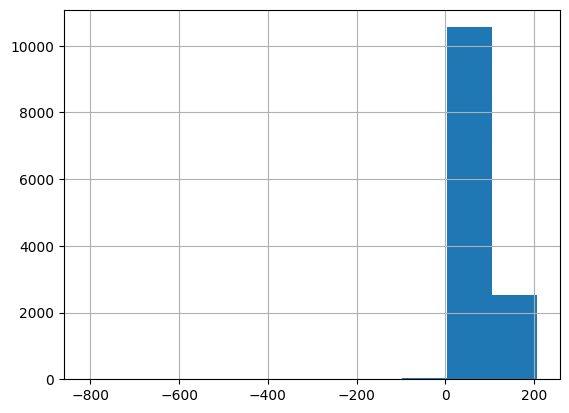

In [110]:
reading = new_df['processesd_messages'].apply(lambda x : flesch_reading_ease(x))
reading.hist()

In [111]:
x=[i for i in range(len(reading)) if reading[i] < 0] # how are more complex texts?
new_df.iloc[x]['processesd_messages'].head(10)

588                                             Ahhhhhhh!
687                                               Exactly
1225                                    Essentially, yes.
1882                                 post-stab relations*
2222                                          Absolutely.
2431    Haha 😂. Moderately squirrelly is pretty accurate.
2506                                          Interesting
2535                       That's really interesting haha
3026                                     Nothing personal
3062                                               Lollll
Name: processesd_messages, dtype: object

---
### Embedings

In [114]:

def bert_family_embeddings(name, tokenizer, model, text):
    # tokenize all the texts and the convert tokens to ids
    tokenized_texts = tokenizer(list(text), return_tensors='pt', padding='max_length', truncation=True, max_length = 128)
    # pass the tokenized texts through the  model
    with torch.no_grad():
        outputs = model(**tokenized_texts)
    # extract the embeddings (last layer's hidden states)
    model_embeddings = outputs.last_hidden_state
    vocab_size = tokenizer.vocab_size
    return model_embeddings , vocab_size

In [115]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
embedings['BERT'] , vocab_sizes['BERT'] = bert_family_embeddings('BERT', tokenizer, model, new_df['processesd_messages'])

KeyboardInterrupt: 